In [3]:
import os
import pandas as pd
import scanpy as sc
import numpy  as np

def generate_anndata_replicates(base_path, output_path):
    """
    Generate AnnData objects for each replicate based on the specific file naming scheme 
    and save them to the output directory.

    Parameters:
    - base_path (str): Base path containing the directories `ST_sim`, `CITE_sim`, etc.
    - output_path (str): Directory where the .h5ad files will be saved.
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Define base directories for each dataset type
    st_gex_dir = os.path.join(base_path, 'ST_sim')
    cite_sim_dir = os.path.join(base_path, 'CITE_sim')

    # Loop through each replicate 0-4
    for i in range(5):
        # Construct paths for each file type, adjusting for specific filenames
        gene_expression_path = os.path.join(st_gex_dir, f'Wu_ST_{i}_data.csv')
        protein_expression_path = os.path.join(cite_sim_dir, f'Wu_CITE_{i}_data.csv')
        spot_index_path = os.path.join(st_gex_dir, f'Wu_ST_{i}_index.csv')
        spot_meta_path = os.path.join(st_gex_dir, f'Wu_ST_{i}_meta.csv')
        cell_type_proportions_path = os.path.join(st_gex_dir, f'Wu_ST_{i}_prop.csv')
        
        # Load replicate-specific data
        gene_expression = pd.read_csv(gene_expression_path, index_col=0)
        protein_expression = pd.read_csv(protein_expression_path, index_col=0)
        spot_index = pd.read_csv(spot_index_path)
        spot_meta = pd.read_csv(spot_meta_path, index_col=1)
        cell_type_proportions = pd.read_csv(cell_type_proportions_path, index_col=0)

        # Create AnnData objects for gene expression and protein expression
        adata_gex = sc.AnnData(gene_expression.T)
        adata_cite = sc.AnnData(protein_expression.T)
        
        # Add spatial coordinates and cell type proportions to AnnData objects
        adata_gex.obsm['spatial'] = spot_meta[['spot_x', 'spot_y']].to_numpy()
        adata_cite.obsm['spatial'] = spot_meta[['spot_x', 'spot_y']].to_numpy()
        
        adata_gex.obs = adata_gex.obs.join(cell_type_proportions, how='left')
        adata_cite.obs = adata_cite.obs.join(cell_type_proportions, how='left')

        # Prepare GEX adata
        adata_gex.X_norm_log1p = adata_gex.X
        adata_gex.X      = np.expm1(adata_gex.X_norm_log1p).round()
    
        # Save each AnnData object with unique names per replicate
        adata_gex.write(os.path.join(output_path, f"Wu_rep_{i}_GEX.h5ad"))
        adata_cite.write(os.path.join(output_path, f"Wu_rep_{i}_CITE.h5ad"))
        
        print(f"Saved Wu_ST_{i} gene expression and Wu_CITE_{i} CITE data to {output_path}")

# Define base path and output path
base_path = "/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg"
output_path = os.path.join(base_path, "h5ad_objects")

# Run the function
generate_anndata_replicates(base_path, output_path)


# Define base path and output path
base_path = "/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/mixed"
output_path = os.path.join(base_path, "h5ad_objects")

# Run the function
generate_anndata_replicates(base_path, output_path)

Saved Wu_ST_0 gene expression and Wu_CITE_0 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg/h5ad_objects
Saved Wu_ST_1 gene expression and Wu_CITE_1 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg/h5ad_objects
Saved Wu_ST_2 gene expression and Wu_CITE_2 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg/h5ad_objects
Saved Wu_ST_3 gene expression and Wu_CITE_3 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg/h5ad_objects
Saved Wu_ST_4 gene expression and Wu_CITE_4 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/high_seg/h5ad_objects
Saved Wu_ST_0 gene expression and Wu_CITE_0 CITE data to /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/

In [1]:
import os
import pandas as pd
import scanpy as sc

test_1 = sc.read_h5ad("/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/mixed/h5ad_objects/Wu_rep_0_GEX.h5ad")

In [2]:
test_1

AnnData object with n_obs × n_vars = 951 × 29733
    obs: 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells', 'spot_x', 'spot_y'
    obsm: 'spatial'

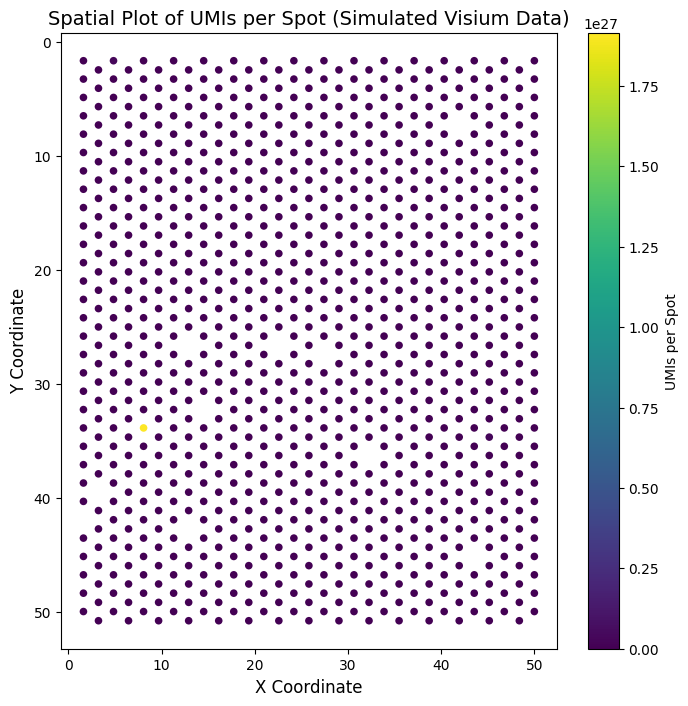

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate inverse log1p of the counts matrix
test_1.layers["raw_counts"] = np.round(np.exp(test_1.X) - 1)

# Calculate UMIs per spot
test_1.obs["UMIs_per_spot"] = test_1.layers["raw_counts"].sum(axis=1)

# Spatial plot of UMIs per spot
if "spatial" in test_1.obsm:
    spatial_coords = test_1.obsm["spatial"]
    
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        spatial_coords[:, 0], spatial_coords[:, 1], 
        c=test_1.obs["UMIs_per_spot"], cmap="viridis", s=30, edgecolor="none"
    )
    plt.colorbar(scatter, label="UMIs per Spot")
    plt.title("Spatial Plot of UMIs per Spot (Simulated Visium Data)", fontsize=14)
    plt.xlabel("X Coordinate", fontsize=12)
    plt.ylabel("Y Coordinate", fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis to match Visium conventions
    plt.grid(False)
    plt.show()
else:
    print("Spatial coordinates not found in test_1.obsm['spatial'].")

In [3]:
from anndata import AnnData
from fast_matrix_market import mmread

def load_wu_data(path, test_mode=False):
    matrix_path = os.path.join(path, "matrix.mtx")
    genes_path = os.path.join(path, "genes.tsv")
    barcodes_path = os.path.join(path, "barcodes.tsv")
    metadata_path = os.path.join(path, "metadata.csv")
    try:
        genes_df = pd.read_csv(genes_path, header=None, sep="\t")
        barcodes_df = pd.read_csv(barcodes_path, header=None)
        barcodes = barcodes_df[0]

        matrix = mmread(matrix_path).T.tocsc().tocsr().astype("float32")
        var_df = pd.DataFrame(index=genes_df[0])
        
        # Create the initial AnnData object
        adata = AnnData(
            matrix, obs=pd.DataFrame(index=barcodes), var=var_df
        )

        # Load the metadata
        metadata_df = pd.read_csv(metadata_path, index_col=0)
        adata.obs['patient_ID'] = metadata_df['orig.ident']
        adata.obs['celltype']   = metadata_df['celltype_major']
        adata.obs["tissue"]     = "Cancer"
        adata.obs["subtype"]    = metadata_df['subtype']
        adata.obs.index.name = None
        if test_mode:
            # Downsample in test mode
            adata = adata[np.random.choice(adata.shape[0], 10000, replace=False)]

        return adata

    except Exception as e:
        print("Error in load_wu_data function:", e)
        raise
wu_path = "/bgfs/alee/LO_LAB/General/Public_Data/BC-Datasets/Wu_2021/Wu_etal_2021_BRCA_scRNASeq"
test_mode = False

# load the ER+ reference dataset
wu_adata = load_wu_data(wu_path, test_mode)

In [4]:
# reshaping the reference
wu_data = pd.DataFrame(wu_adata.X.toarray(), 
                       index=wu_adata.obs.index,    # Cell names
                       columns=wu_adata.var.index)  # Gene names

wu_data.sum(axis=1).describe()

count    100064.000000
mean       7139.312988
std        9947.079102
min         252.000000
25%        1922.000000
50%        3573.000000
75%        7962.000000
max      181558.000000
dtype: float64

In [9]:
test_1.obs["UMIs_per_spot"].describe()

count    9.510000e+02
mean     2.096499e+24
std               inf
min      2.880000e+03
25%      4.387282e+07
50%      7.065756e+10
75%      2.603243e+14
max      1.915687e+27
Name: UMIs_per_spot, dtype: float64

In [11]:
import os
import pandas as pd
import numpy as np

# Directory containing the cell-type-specific files
cell_type_dir = "/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/scCube_12k/replicates/mixed/ST_GEX_sim/sample_0/layers"  # Replace with the actual path

# Read and sum cell-type-specific gene expression profiles
gene_expression_profiles = []
for file_name in os.listdir(cell_type_dir):
    if file_name.endswith(".csv"):  # Only process .csv files
        file_path = os.path.join(cell_type_dir, file_name)
        gene_expression_profiles.append(pd.read_csv(file_path, index_col=0))

# Sum all cell-type-specific profiles
summed_expression = sum(gene_expression_profiles)

# Ensure the summed matrix matches the raw counts
raw_counts = test_1.X  # Inverse log1p transformation of test_1.X

# Check if they are approximately equal
if np.allclose(summed_expression.values, raw_counts, atol=1e-6):
    print("The summed gene expression profiles match the raw counts in test_1.")
    
    # Add the summed matrix as "raw_counts" in the AnnData object (if needed)
    test_1.layers["raw_counts"] = np.round(raw_counts)
    
    # Calculate UMIs per spot
    test_1.obs["UMIs_per_spot"] = test_1.layers["raw_counts"].sum(axis=1)
else:
    print("The summed gene expression profiles do not match the raw counts in test_1.")

# Optionally inspect differences if they don't match
if not np.allclose(summed_expression.values, raw_counts, atol=1e-6):
    difference = np.abs(summed_expression.values - raw_counts)
    print("Max difference:", difference.max())
    print("Mean difference:", difference.mean())

The summed gene expression profiles do not match the raw counts in test_1.
Max difference: 5000.0
Mean difference: 0.796376722571459
